# Shakhnazar Kapar, Murat Almas, Aniyar Baibossyn
Final project - "Skin cancer detection"

In [65]:
import os
import numpy as np
import tensorflow as tf
import shutil
import pandas as pd
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import load_model
from google.colab import files



# Connecting to google drive(We used Almas's google drive).
We uploaded dataset to google drive for convenience.
Actual dataset link where we get dataset is  = `https://universe.roboflow.com/redronin/preprocessing-and-augmentations-zl5il/model/11`


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define the paths to the training, validation, and testing directories


In [48]:
train_dir = '/content/drive/MyDrive/skin cancer dataset/train'
valid_dir = '/content/drive/MyDrive/skin cancer dataset/valid'
test_dir = '/content/drive/MyDrive/skin cancer dataset/test'

In [49]:
# Get the class names
class_names = os.listdir(train_dir)

# print list class names
print("Classes in the dataset:")
print(class_names)

Classes in the dataset:
['malignant', 'benign']


In [50]:
# show paths images in the train class
imagepaths = list(glob(train_dir + "/**/*.*"))
print(imagepaths)

['/content/drive/MyDrive/skin cancer dataset/train/malignant/1030_jpg.rf.249410d44be260d69d3dea49e30bfe1e.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1027_jpg.rf.e9b560e1a6c33f9aa9d46dd941054909.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1027_jpg.rf.d5adad6f41ae345b00371529699fafe7.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1026_jpg.rf.3492c06625ad24449870e9f425bac6f4.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1025_jpg.rf.a7cbc093f8e63dd749d4eca53b270a97.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1026_jpg.rf.648ae5cba64cdf22faff9e7a0086e549.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1023_jpg.rf.beb6c5fa49f2849b5cec7bb585956fec.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1022_jpg.rf.77946d74dce60880f7d97fa5519ad51a.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1022_jpg.rf.b9b73345ac60c65aec0b760504e8c9d0.jpg', 

# What contain our dataset?

In [51]:
# Initialize a dictionary to store the image counts for each class
class_image_counts = {}

for class_label in class_names:
    class_dir_train = os.path.join(train_dir, class_label)
    class_dir_valid = os.path.join(valid_dir, class_label)
    class_dir_test = os.path.join(test_dir, class_label)

    num_images_train = len(os.listdir(class_dir_train))
    num_images_valid = len(os.listdir(class_dir_valid))
    num_images_test = len(os.listdir(class_dir_test))

    total_images = num_images_train + num_images_valid + num_images_test

    class_image_counts[class_label] = total_images
for class_label, count in class_image_counts.items():
    print(f"Class: {class_label}, have images: {count}")

# Calculate the overall number of images in the dataset
overall_images = sum(class_image_counts.values())
print("Overall images in the dataset:", overall_images)

Class: malignant, have images: 1345
Class: benign, have images: 1348
Overall images in the dataset: 2693


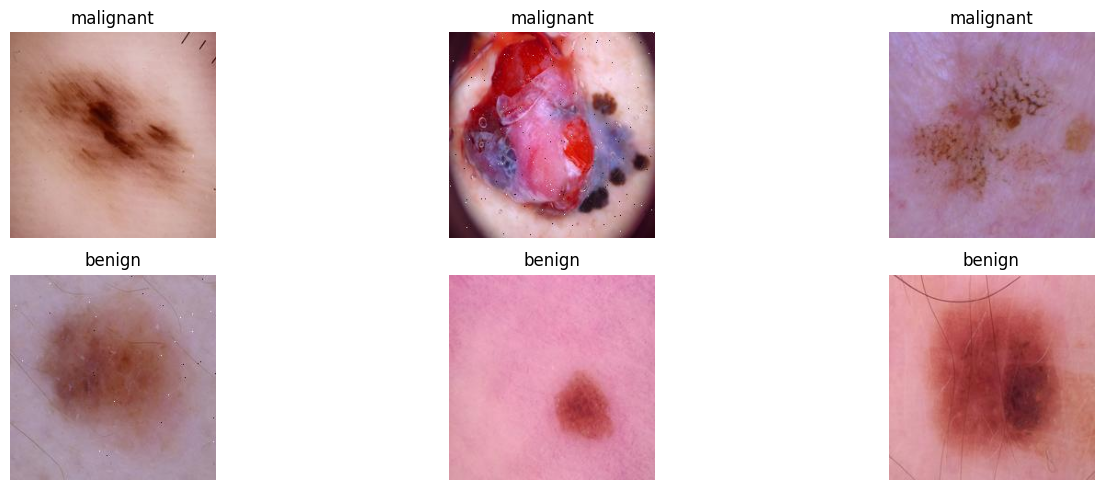

In [52]:

def show_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)

        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display sample images
show_sample_images(train_dir, class_names)


In [53]:
# Create a DataFrame to store image paths and labels
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)

    for class_label in class_names:
        class_dir = os.path.join(data_dir, class_label)
        image_files = os.listdir(class_dir)
        image_paths.extend([os.path.join(class_dir, img) for img in image_files])
        labels.extend([class_label] * len(image_files))

    return pd.DataFrame({'ImagePath': image_paths, 'Label': labels})

# Create DataFrames for each dataset
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)


print(train_df.head())
print("\n")
print(train_df.tail())

print("\n\n\n")

print(valid_df.head())
print("\n")
print(valid_df.tail())

print("\n\n\n")

print(test_df.head())
print("\n")
print(test_df.tail())


                                           ImagePath      Label
0  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
1  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
2  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
3  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
4  /content/drive/MyDrive/skin cancer dataset/tra...  malignant


                                              ImagePath   Label
1795  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1796  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1797  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1798  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1799  /content/drive/MyDrive/skin cancer dataset/tra...  benign




                                           ImagePath   Label
0  /content/drive/MyDrive/skin cancer dataset/val...  benign
1  /content/drive/MyDrive/skin cancer dataset/val...  benign
2  /content/drive/MyDrive/skin cancer datas

<Figure size 800x600 with 0 Axes>

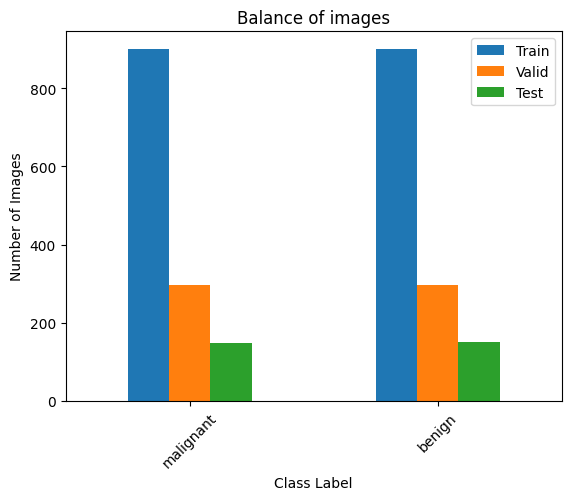

Train Dataset:
malignant    900
benign       900
Name: Label, dtype: int64

Validation Dataset:
benign       298
malignant    297
Name: Label, dtype: int64

Test Dataset:
benign       150
malignant    148
Name: Label, dtype: int64


In [54]:
# Get the counts for each class in each dataset
train_counts = train_df['Label'].value_counts()
valid_counts = valid_df['Label'].value_counts()
test_counts = test_df['Label'].value_counts()

class_counts = pd.concat([train_counts, valid_counts, test_counts], axis=1, keys=['Train', 'Valid', 'Test'])

# Plot the balance of images
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Balance of images')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print("Train Dataset:")
print(train_counts)
print("\nValidation Dataset:")
print(valid_counts)
print("\nTest Dataset:")
print(test_counts)


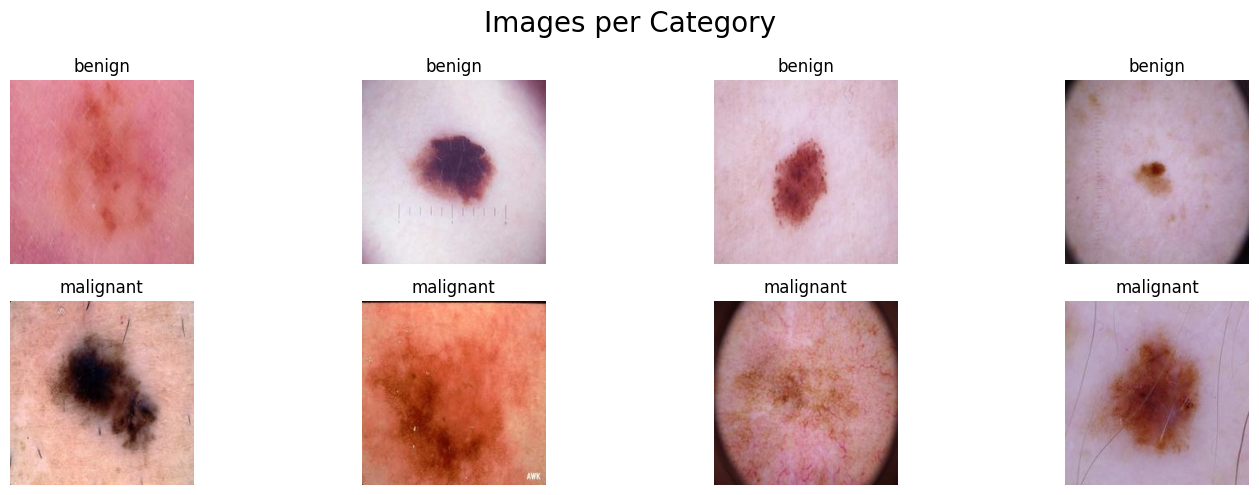

In [60]:
def show_images_per_category(df, num_images=4, figsize=(15, 5)):
    categories = df['Label'].unique()
    num_categories = len(categories)

    fig, ax = plt.subplots(num_categories, num_images, figsize=figsize)
    fig.suptitle('Images per Category', fontsize=20)

    for i, cat in enumerate(categories):
        indices = df[df['Label'] == cat].index
        num_indices = len(indices)

        # Get random indices or None if no images found
        random_indices = random.sample(indices.tolist(), min(num_images, num_indices)) if num_indices > 0 else [None] * num_images

        # Iterate over each image column
        for j, idx in enumerate(random_indices):
            if idx is not None:
                img_path = df.loc[idx, 'ImagePath']
                img = np.array(Image.open(img_path))
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{cat}')
            else:
                ax[i, j].axis('off')
                ax[i, j].text(0.5, 0.5, f"No images found for {cat}", horizontalalignment='center', verticalalignment='center', fontsize=12)

            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_images_per_category(test_df)


# Main part goes here!
Data preprocessing and augmentation


In [61]:
# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Create data generators


In [62]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 1800 images belonging to 2 classes.
Found 595 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


# Build the model


In [63]:
# Define base model
base_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Freeze the weights of the base model
base_model.trainable = False

# Top model Conv2D layers with padding
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 32)          737312    
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 global_average_pooling2d_3  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)              

In [64]:
model.save('/content/drive/MyDrive/skin cancer dataset/cancerDetectionModel.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Fitting, Evaluating, Plotting the model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Accuracy:", test_accuracy)


56/56 [==============================] - 1370s 24s/step - loss: 0.7414 - accuracy: 0.5153 - val_loss: 1.7935 - val_accuracy: 0.4983
Epoch 2/10
11/56 [====>.........................] - ETA: 13:58 - loss: 0.7681 - accuracy: 0.4545

# Plot training history


In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Interesting numbers


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on test data
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions).flatten()

print("\nAdditional Metrics:")
print("Classification Report:")
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Real predictiong some images


Saving 28_jpg.rf.177e4d1ba39c89566dcf318decf0a94a.jpg to 28_jpg.rf.177e4d1ba39c89566dcf318decf0a94a.jpg
1/1 [==============================] - 8s 8s/step


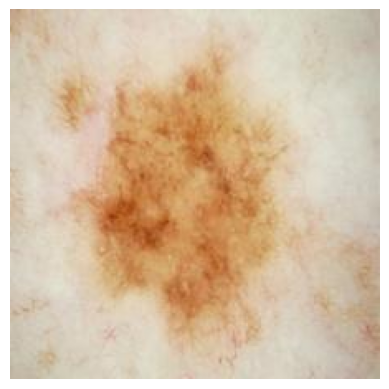

Predicted class: Benign
Confidence: 0.5203588008880615


In [66]:
# Define a function to preprocess the uploaded image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array

# Load the trained model
model = load_model('/content/drive/MyDrive/skin cancer dataset/cancerDetectionModel.h5')

def predict_uploaded_image(model, image_path):
    img = preprocess_image(image_path)

    # Make predictions
    prediction = model.predict(np.expand_dims(img, axis=0))

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if prediction >= 0.5:
        print("Predicted class: Malignant")
        print("Confidence:", prediction[0][0])
    else:
        print("Predicted class: Benign")
        print("Confidence:", 1 - prediction[0][0])

upload_button = files.upload()

uploaded_image_path = list(upload_button.keys())[0]

predict_uploaded_image(model, uploaded_image_path)
